In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from data import load_database_train
from preprocessing import InterpolateRawData
from train import grid_search, scikit_train_validate
from sklearn.model_selection import cross_val_score
from cross_validation import cv_folds_author
import numpy as np
from plotter import plot_all_readings


%matplotlib inline

In [2]:
database_train = load_database_train()
X_processed = InterpolateRawData(num_samples=40).fit_transform(database_train.X)

# Modelo Base

## Analisando quantidade de amostragem na interpolação dos dados 

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   16.3s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:   21.2s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:   43.5s
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:   57.7s
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  2.3min
[Parallel(n_jobs=6)]: Done  49 tasks      | elapsed:  2.9min
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed:  3.7min
[Parallel(n_jobs=6)]: Done  78 out of  80 | elapsed:  4.7min remaining:    7.2s
[Parallel(n_jobs=6)]: Done  80 out of  80 | elapsed:  4.7min finished


,params,mean_train_score,std_train_score,mean_test_score,std_test_score
0,{'interpolate__num_samples': 5},0.94,0.03,0.65,0.15
1,{'interpolate__num_samples': 10},1.00,0.00,0.65,0.12
2,{'interpolate__num_samples': 20},1.00,0.00,0.68,0.14
3,{'interpolate__num_samples': 40},1.00,0.00,0.71,0.14
4,{'interpolate__num_samples': 80},1.00,0.00,0.70,0.14
5,{'interpolate__num_samples': 120},1.00,0.00,0.70,0.15
6,{'interpolate__num_samples': 240},1.00,0.00,0.70,0.14
7,"{'interpolate__max_time': 6000, 'interpolate__num_samples': None, 'interpolate__timestep': 10}",1.00,0.00,0.49,0.20
8,"{'interpolate__max_time': 6000, 'interpolate__num_samples': None, 'interpolate__timestep': 50}",1.00,0.00,0.48,0.20
9,"{'interpolate__max_time': 6000, 'interpolate__num_samples': None, 'interpolate__timestep': 100}",1.00,0.00,0.46,0.20


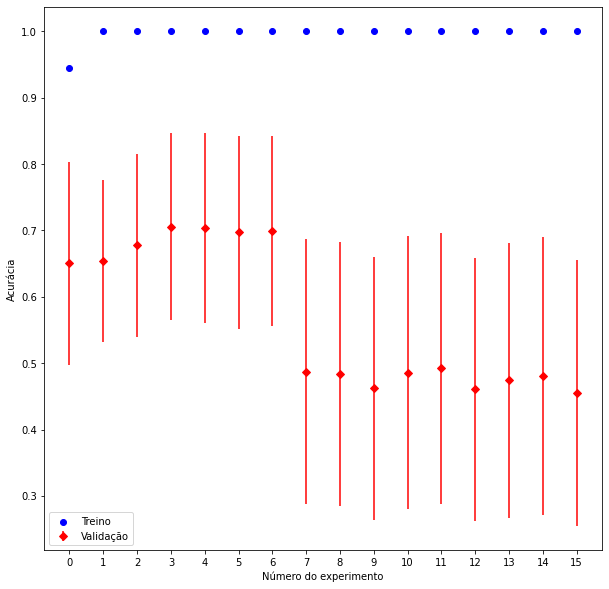

,params,mean_train_score,std_train_score,mean_test_score,std_test_score
3,{'interpolate__num_samples': 40},1.00,0.00,0.71,0.14


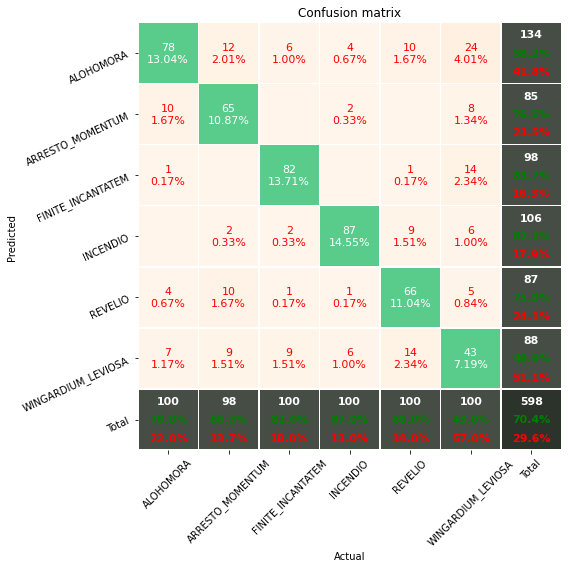

Pipeline(steps=[('interpolate', InterpolateRawData(num_samples=40)),
                ('logistic',
                 LogisticRegression(max_iter=100000, random_state=0))])

In [3]:
pipe = Pipeline([
    ('interpolate', InterpolateRawData()),
    ('logistic', LogisticRegression(random_state=0, max_iter=100000))
])

parameters = [
    {'interpolate__num_samples': [5, 10, 20, 40, 80, 120, 240]},
    
    {'interpolate__num_samples': [None], 
     'interpolate__timestep': [10, 50, 100], 
     'interpolate__max_time': [6000, 5000, 4000] 
    }
]

grid_search(pipe, parameters, database_train.X, database_train.y, database_train.cv_author, n_jobs=6)

Segundo modelo base de **Regressão Logistica**, o num_samples = 80 trouxe bons resultados, e maiores amostragens não trouxeram mudanças significativas. Nosso método grid_search já faz o Kfold considerando como divisaão de dados os autores (**cv_folds_author**)

Olhando os scores abaixo, percebemos como houve muita variação entre os folds, visto que cada fold é um autor com celular diferente que não tem no modelo.

In [4]:
pipe = Pipeline([
    ('logistic', LogisticRegression(random_state=0, max_iter=100000))
])

print(cross_val_score(pipe, X_processed, database_train.y, cv=database_train.cv_author))

[0.49166667 0.80833333 0.875      0.58333333 0.76271186]


Se não usassemos este método, e os dados fossem misturado, o resultado do modelo seria muito enviesado como abaixo, onde manteve uma boa acurácia acima dos 84% em todos os folds

In [5]:
print(cross_val_score(pipe, X_processed, database_train.y, cv=5))

[0.88333333 0.89166667 0.89166667 0.90756303 0.84033613]


# Random Forest

## Oque é
Esse método cria várias arvores de decisão, de maneira aletória (formando um floresta), onde cada arvore será utilizada na escolha do resultado final. \
O Random Forest faz parte de um grupo de métodos conhecidos como métodos 'ensemble', onde a principal característica é a combinação de diferentes modelos para se obter um único resultado. Com isso o algoritmo se tonar mais robusto e complexo. \

## Como funciona
A primeira parte do algoritmo é montar a arvore de decisão, com isso cada nó passa a possuir uma condição a ser verificada e se atendida o fluxo segue por um ramo, caso contrário, por outro, até a finalização da arvore. \
Para montar as arvores, são escolhidas aleatoriamente algumas amostras dos dados de treino (através do parametro bootstrap) e com essa seleção é construída a primeira arvore de seleção. \
Para escolha do nó raiz é utilizado o algoritmo do parametro criterion (Gini ou entropy). Esses algoritmos retornam de maneira aleatória duas ou mais variáveis que serão utilizadas para realizar os calculos com base nas amostras selecionadas e então definir a melhor para ser o primeiro nó. E os nós são escolhidos da mesma forma sucessivamente. \
Cada árvore é construída dessa maneira e provavelmente será um diferente da outra devido ao fato de tanto a seleção de amostras quanto a seleção de variaveis ocorrerem de maneira aleatória. Com isso também é evitado o overfitting.

## Em outras palavras
Para classificar um novo objeto baseado em atributos, cada árvore dá uma classificação, que é como se a árvore desse “votos” para essa classe. A floresta escolhe a classificação que tiver mais votos (de todas as árvores da floresta) e, em caso de regressão, considera a média das saídas por árvores diferentes.

## Melhores parametros encontrados
Conforme análises abaixo, o melhor resultado obtido com o método Random Forest foi utilizando os seguintes parametros: \
**Pipeline(steps=[('random', RandomForestClassifier(class_weight='balanced', max_depth=10, max_features=0.6))])**

### Encontrando melhores parametros
Primeiramente efetuamos um teste extenso variando múltiplos parametros simultaneamente, a fim de obter os melhores parametros, após essa análise mais longa, faremos uma análise variando cada um dos parametros individualmente. Os parametros em estudo são os seguintes: \
criterion = Função para mensurar a qualidade da divisão
max_depth = Quando None os nós são expandidos até todas as folhas serem puras ou conterem o min_samples_split
bootstrap = se falso o dataset inteiro é usado para construir cada arvore \
n_estimators = número de arvores na floresta \
max_features = número de features utilizados na busca pela melhor amostragem (como o numero é float, estamos passando uma porcentagem do total de features \
min_samples_leaf = número mínimo de exemplos que são folhas nas arvores \
min_samples_split = Número minimo de exemplos obrigatórios para dividir um nó interno

In [23]:
pipe = Pipeline([
    ('random', RandomForestClassifier(criterion='gini', max_depth=None))
])

print(pipe.get_params().keys())

parameters = {'random__bootstrap': [False, True],
         'random__n_estimators': [80,90, 100, 110, 130],
         'random__max_features': [0.6, 0.65, 0.7, 0.73, 0.7500000000000001, 0.78, 0.8],
         'random__min_samples_leaf': [10, 12, 14],
         'random__min_samples_split': [3, 5, 7]
        }
# grid_search(pipe, parameters, X_processed, database_train.y, database_train.cv_author, n_jobs=6)

dict_keys(['memory', 'steps', 'verbose', 'random', 'random__bootstrap', 'random__ccp_alpha', 'random__class_weight', 'random__criterion', 'random__max_depth', 'random__max_features', 'random__max_leaf_nodes', 'random__max_samples', 'random__min_impurity_decrease', 'random__min_impurity_split', 'random__min_samples_leaf', 'random__min_samples_split', 'random__min_weight_fraction_leaf', 'random__n_estimators', 'random__n_jobs', 'random__oob_score', 'random__random_state', 'random__verbose', 'random__warm_start'])


Ao executar os experimentos, os melhores parametros encontrados foram: {'random__bootstrap': True, 'random__max_features': 0.78, 'random__min_samples_leaf': 10, 'random__min_samples_split': 5, 'random__n_estimators': 100}

### Testando diferentes criterios

dict_keys(['memory', 'steps', 'verbose', 'random', 'random__bootstrap', 'random__ccp_alpha', 'random__class_weight', 'random__criterion', 'random__max_depth', 'random__max_features', 'random__max_leaf_nodes', 'random__max_samples', 'random__min_impurity_decrease', 'random__min_impurity_split', 'random__min_samples_leaf', 'random__min_samples_split', 'random__min_weight_fraction_leaf', 'random__n_estimators', 'random__n_jobs', 'random__oob_score', 'random__random_state', 'random__verbose', 'random__warm_start'])
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of  10 | elapsed:    2.4s remaining:    5.7s
[Parallel(n_jobs=6)]: Done   5 out of  10 | elapsed:    2.7s remaining:    2.7s
[Parallel(n_jobs=6)]: Done   7 out of  10 | elapsed:    3.9s remaining:    1.7s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    4.2s finished


,params,mean_train_score,std_train_score,mean_test_score,std_test_score
0,{'random__criterion': 'gini'},1.00,0.00,0.79,0.19
1,{'random__criterion': 'entropy'},1.00,0.00,0.78,0.20


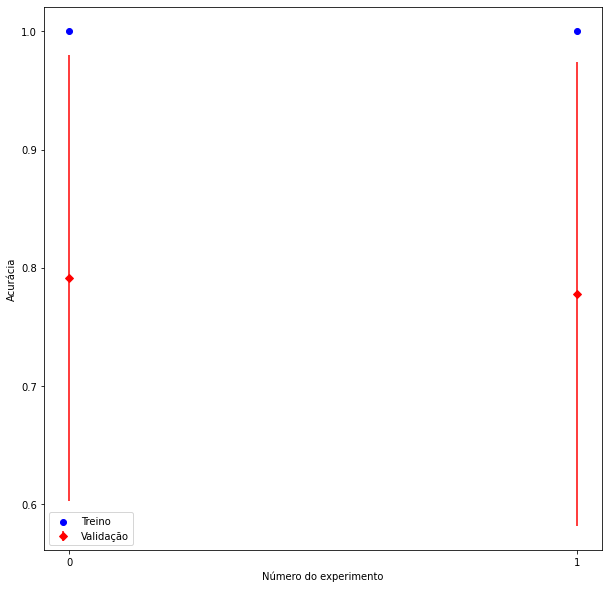

,params,mean_train_score,std_train_score,mean_test_score,std_test_score
0,{'random__criterion': 'gini'},1.00,0.00,0.79,0.19


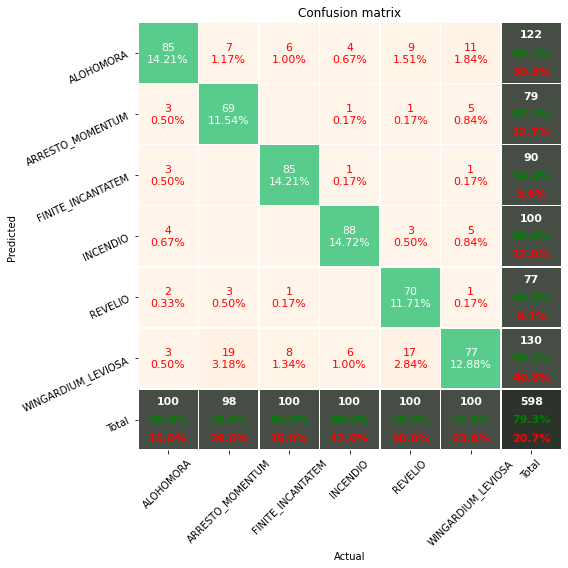

Pipeline(steps=[('random', RandomForestClassifier())])

In [21]:
pipe = Pipeline([
    ('random', RandomForestClassifier())
])

parameters = {'random__criterion': ['gini', 'entropy']}
grid_search(pipe, parameters, X_processed, database_train.y, database_train.cv_author, n_jobs=6)

Apesar da diferença entre os critérios ser pouca, o critério gini é levemente melhor, vamos adotá-lo como padrão (já é o padrão da biblioteca)

### Testando diferentes max_depth

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:    2.0s
[Parallel(n_jobs=6)]: Done  17 out of  25 | elapsed:    2.7s remaining:    1.3s
[Parallel(n_jobs=6)]: Done  20 out of  25 | elapsed:    3.1s remaining:    0.8s
[Parallel(n_jobs=6)]: Done  23 out of  25 | elapsed:    3.5s remaining:    0.3s
[Parallel(n_jobs=6)]: Done  25 out of  25 | elapsed:    3.7s finished


,params,mean_train_score,std_train_score,mean_test_score,std_test_score
0,{'random__max_depth': None},1.00,0.00,0.77,0.21
1,{'random__max_depth': 0},nan,nan,nan,nan
2,{'random__max_depth': 5},1.00,0.00,0.76,0.21
3,{'random__max_depth': 10},1.00,0.00,0.79,0.18
4,{'random__max_depth': 100},1.00,0.00,0.79,0.19


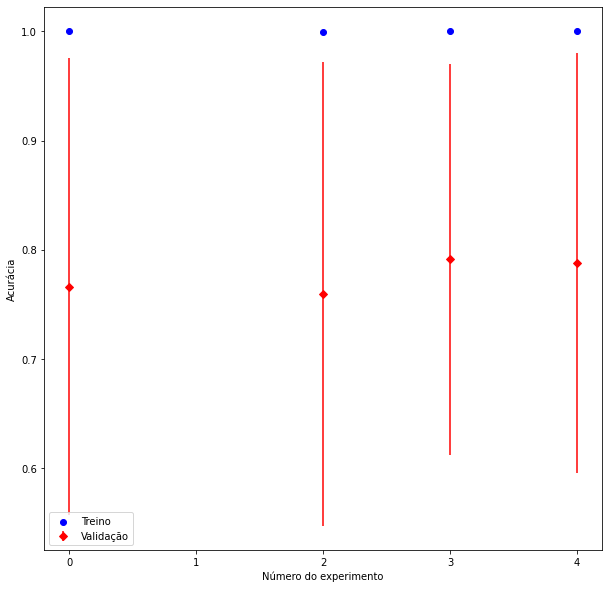

,params,mean_train_score,std_train_score,mean_test_score,std_test_score
3,{'random__max_depth': 10},1.00,0.00,0.79,0.18


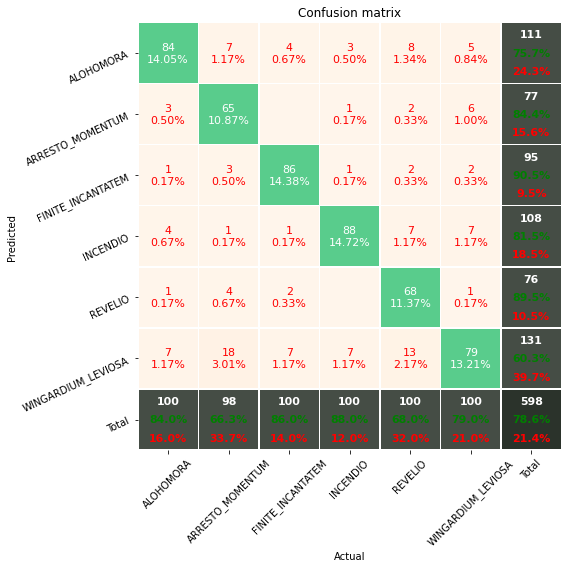

Pipeline(steps=[('random', RandomForestClassifier(max_depth=10))])

In [22]:
pipe = Pipeline([
    ('random', RandomForestClassifier())
])

parameters = {'random__max_depth': [None, 0, 5, 10, 100]}
grid_search(pipe, parameters, X_processed, database_train.y, database_train.cv_author, n_jobs=6)

A diferença entre a profundidade máxima da arvore varia muito pouco, o padrão da biblioteca é não definir uma profundidade, novos testes serão feitos abaixo para definir se usamos profundidade 10 ou não definimos

### Testando Bootstrap

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    2.3s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    2.9s
[Parallel(n_jobs=6)]: Done  12 out of  20 | elapsed:    4.0s remaining:    2.7s
[Parallel(n_jobs=6)]: Done  15 out of  20 | elapsed:    4.8s remaining:    1.6s
[Parallel(n_jobs=6)]: Done  18 out of  20 | elapsed:    5.0s remaining:    0.6s
[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:    5.3s finished


,params,mean_train_score,std_train_score,mean_test_score,std_test_score
0,"{'random__bootstrap': False, 'random__max_depth': None}",1.00,0.00,0.78,0.20
1,"{'random__bootstrap': False, 'random__max_depth': 10}",1.00,0.00,0.77,0.19
2,"{'random__bootstrap': True, 'random__max_depth': None}",1.00,0.00,0.77,0.21
3,"{'random__bootstrap': True, 'random__max_depth': 10}",1.00,0.00,0.81,0.17


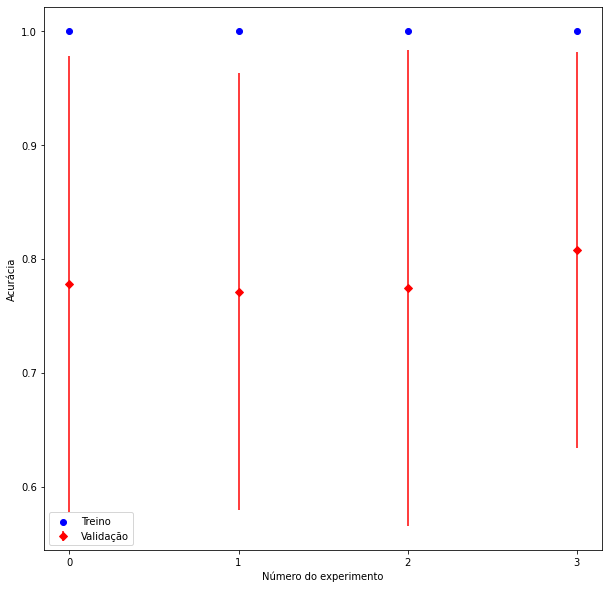

,params,mean_train_score,std_train_score,mean_test_score,std_test_score
3,"{'random__bootstrap': True, 'random__max_depth': 10}",1.00,0.00,0.81,0.17


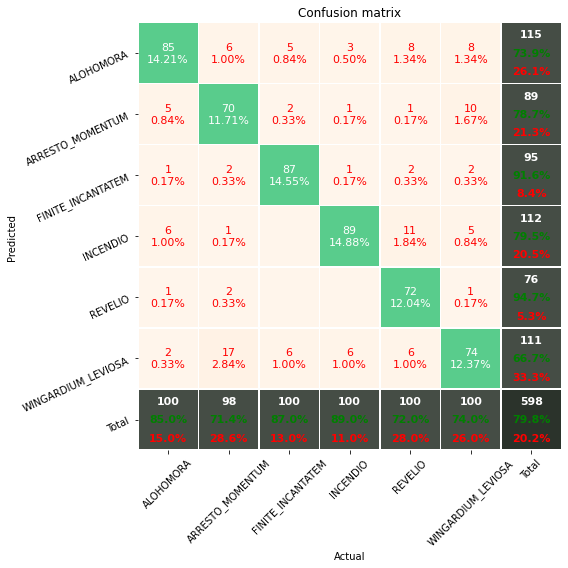

Pipeline(steps=[('random', RandomForestClassifier(max_depth=10))])

In [25]:
pipe = Pipeline([
    ('random', RandomForestClassifier())
])

parameters = {'random__bootstrap': [False, True],
         'random__max_depth': [None, 10]
        }

grid_search(pipe, parameters, X_processed, database_train.y, database_train.cv_author, n_jobs=6)

Vemos que utilizar as amostras de inicialização na construção das arvores é melhor que utilizar todo o conjunto para criar cada arvore, por isso utilizaremos o padrão da biblioteca que é Bootstrap = true

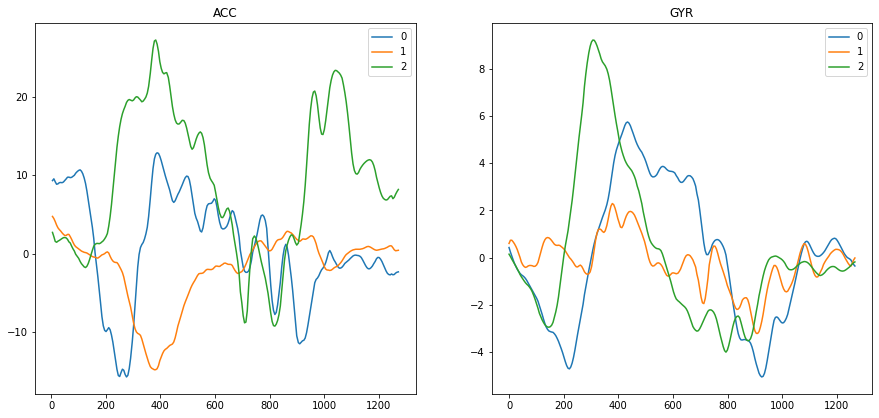

In [26]:
plot_all_readings(database_train.datalist[0].readings, table_format=(0, 2))

### Testando estimators

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    1.0s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:    2.5s
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:    4.2s
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:    5.6s
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    7.3s
[Parallel(n_jobs=6)]: Done  45 out of  50 | elapsed:    8.7s remaining:    1.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    9.5s finished


,params,mean_train_score,std_train_score,mean_test_score,std_test_score
0,"{'random__max_depth': None, 'random__n_estimators': 80}",1.00,0.00,0.77,0.21
1,"{'random__max_depth': None, 'random__n_estimators': 90}",1.00,0.00,0.81,0.18
2,"{'random__max_depth': None, 'random__n_estimators': 100}",1.00,0.00,0.79,0.17
3,"{'random__max_depth': None, 'random__n_estimators': 110}",1.00,0.00,0.80,0.19
4,"{'random__max_depth': None, 'random__n_estimators': 130}",1.00,0.00,0.77,0.21
5,"{'random__max_depth': 10, 'random__n_estimators': 80}",1.00,0.00,0.78,0.20
6,"{'random__max_depth': 10, 'random__n_estimators': 90}",1.00,0.00,0.79,0.20
7,"{'random__max_depth': 10, 'random__n_estimators': 100}",1.00,0.00,0.78,0.19
8,"{'random__max_depth': 10, 'random__n_estimators': 110}",1.00,0.00,0.80,0.19
9,"{'random__max_depth': 10, 'random__n_estimators': 130}",1.00,0.00,0.78,0.20


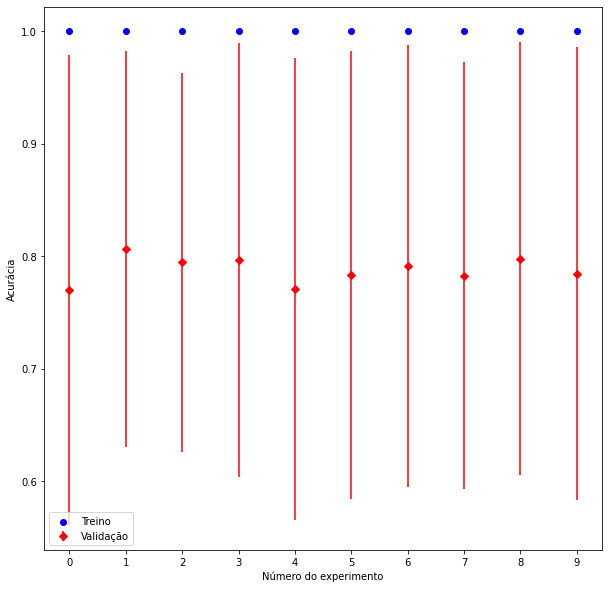

,params,mean_train_score,std_train_score,mean_test_score,std_test_score
1,"{'random__max_depth': None, 'random__n_estimators': 90}",1.00,0.00,0.81,0.18


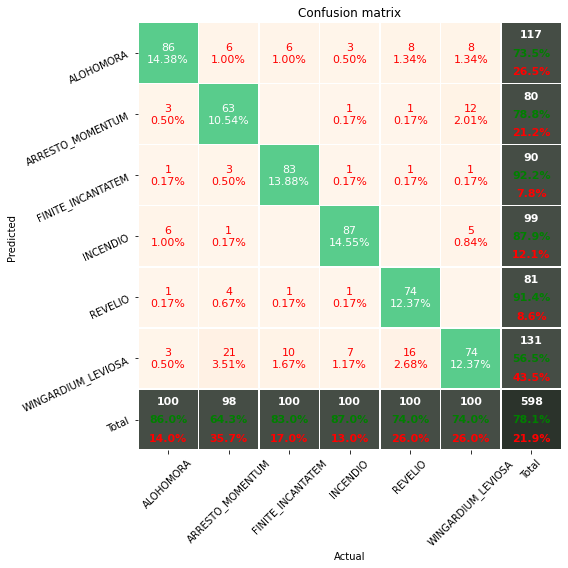

Pipeline(steps=[('random', RandomForestClassifier(n_estimators=90))])

In [28]:
pipe = Pipeline([
    ('random', RandomForestClassifier())
])

parameters = {
         'random__n_estimators': [80,90, 100, 110, 130],
         'random__max_depth': [None, 10]
        }
grid_search(pipe, parameters, X_processed, database_train.y, database_train.cv_author, n_jobs=6)

Vimos agora que a profundidade da arvore ideal não é mais 10, mas indefinida quando utilizamos um estimators = 90.
Como os números são bem próximos faremos novos testes com estimators = [90, 100]

### Testando min samples leaf

dict_keys(['memory', 'steps', 'verbose', 'random', 'random__bootstrap', 'random__ccp_alpha', 'random__class_weight', 'random__criterion', 'random__max_depth', 'random__max_features', 'random__max_leaf_nodes', 'random__max_samples', 'random__min_impurity_decrease', 'random__min_impurity_split', 'random__min_samples_leaf', 'random__min_samples_split', 'random__min_weight_fraction_leaf', 'random__n_estimators', 'random__n_jobs', 'random__oob_score', 'random__random_state', 'random__verbose', 'random__warm_start'])
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    2.3s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    2.7s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:    3.9s
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:    5.4s
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:    6.4s
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    7.8s
[Parallel(n_jobs=6)]: Done  49 tasks      | elapsed:    8.9s
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed:   10.7s
[Parallel(n_jobs=6)]: Done  73 tasks      | elapsed:   12.5s
[Parallel(n_jobs=6)]: Done  86 tasks      | elapsed:   14.5s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:   15.9s remaining:    0.0s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:   15.9s finished


,params,mean_train_score,std_train_score,mean_test_score,std_test_score
0,"{'random__max_depth': None, 'random__min_samples_leaf': 10, 'random__n_estimators': 90}",0.97,0.01,0.75,0.22
1,"{'random__max_depth': None, 'random__min_samples_leaf': 10, 'random__n_estimators': 100}",0.97,0.01,0.74,0.22
2,"{'random__max_depth': None, 'random__min_samples_leaf': 12, 'random__n_estimators': 90}",0.96,0.01,0.75,0.23
3,"{'random__max_depth': None, 'random__min_samples_leaf': 12, 'random__n_estimators': 100}",0.96,0.01,0.76,0.22
4,"{'random__max_depth': None, 'random__min_samples_leaf': 14, 'random__n_estimators': 90}",0.95,0.02,0.73,0.23
5,"{'random__max_depth': None, 'random__min_samples_leaf': 14, 'random__n_estimators': 100}",0.95,0.02,0.74,0.23
6,"{'random__max_depth': None, 'random__min_samples_leaf': 50, 'random__n_estimators': 90}",0.88,0.04,0.71,0.23
7,"{'random__max_depth': None, 'random__min_samples_leaf': 50, 'random__n_estimators': 100}",0.88,0.04,0.71,0.23
8,"{'random__max_depth': None, 'random__min_samples_leaf': 100, 'random__n_estimators': 90}",0.76,0.06,0.58,0.18
9,"{'random__max_depth': None, 'random__min_samples_leaf': 100, 'random__n_estimators': 100}",0.72,0.06,0.57,0.17


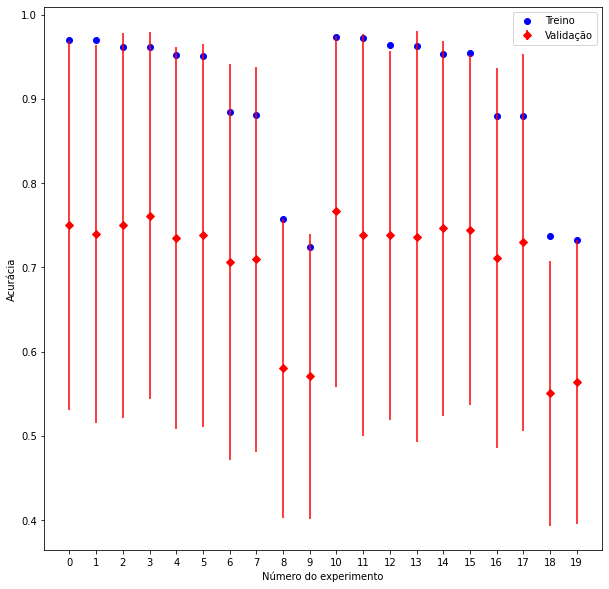

,params,mean_train_score,std_train_score,mean_test_score,std_test_score
10,"{'random__max_depth': 10, 'random__min_samples_leaf': 10, 'random__n_estimators': 90}",0.97,0.01,0.77,0.21


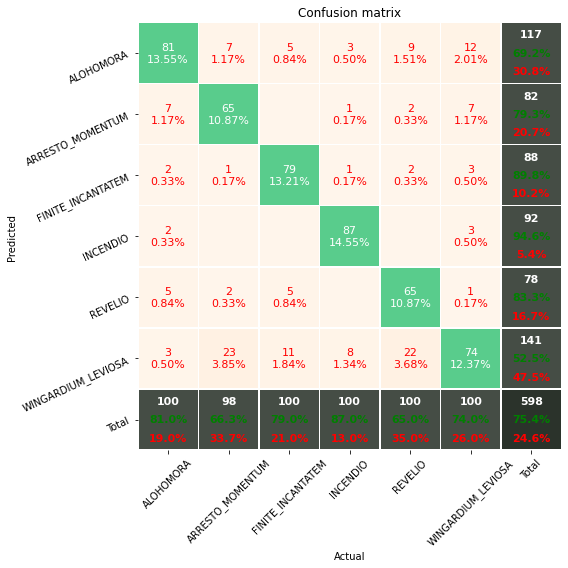

Pipeline(steps=[('random',
                 RandomForestClassifier(max_depth=10, min_samples_leaf=10,
                                        n_estimators=90))])

In [29]:
pipe = Pipeline([
    ('random', RandomForestClassifier())
])

print(pipe.get_params().keys())

parameters = {
         'random__min_samples_leaf': [10, 12, 14, 50, 100],
         'random__n_estimators': [90, 100],
         'random__max_depth': [None, 10],
        }

grid_search(pipe, parameters, X_processed, database_train.y, database_train.cv_author, n_jobs=6)

Com esse teste vimos que o min samples leaf = 10 trouxe melhores resultados, ou seja, o número mínimo de amostras necessárias para estar em um nó folha é 10. O padrão da biblioteca é 1

### Testando min samples split

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    1.1s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:    3.2s
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:    4.4s
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:    5.8s
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    7.4s
[Parallel(n_jobs=6)]: Done  49 tasks      | elapsed:    8.7s
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed:   10.1s
[Parallel(n_jobs=6)]: Done  73 tasks      | elapsed:   12.3s
[Parallel(n_jobs=6)]: Done  86 tasks      | elapsed:   14.4s
[Parallel(n_jobs=6)]: Done 101 tasks      | elapsed:   17.2s
[Parallel(n_jobs=6)]: Done 120 out of 120 | elapsed:   19.7s finished


,params,mean_train_score,std_train_score,mean_test_score,std_test_score
0,"{'random__max_depth': None, 'random__min_samples_split': 2, 'random__n_estimators': 90}",1.00,0.00,0.77,0.18
1,"{'random__max_depth': None, 'random__min_samples_split': 2, 'random__n_estimators': 100}",1.00,0.00,0.78,0.19
2,"{'random__max_depth': None, 'random__min_samples_split': 5, 'random__n_estimators': 90}",1.00,0.00,0.78,0.21
3,"{'random__max_depth': None, 'random__min_samples_split': 5, 'random__n_estimators': 100}",1.00,0.00,0.79,0.19
4,"{'random__max_depth': None, 'random__min_samples_split': 7, 'random__n_estimators': 90}",1.00,0.00,0.78,0.19
5,"{'random__max_depth': None, 'random__min_samples_split': 7, 'random__n_estimators': 100}",1.00,0.00,0.78,0.19
6,"{'random__max_depth': None, 'random__min_samples_split': 10, 'random__n_estimators': 90}",1.00,0.00,0.76,0.21
7,"{'random__max_depth': None, 'random__min_samples_split': 10, 'random__n_estimators': 100}",1.00,0.00,0.76,0.21
8,"{'random__max_depth': None, 'random__min_samples_split': 50, 'random__n_estimators': 90}",0.94,0.02,0.76,0.23
9,"{'random__max_depth': None, 'random__min_samples_split': 50, 'random__n_estimators': 100}",0.94,0.02,0.72,0.24


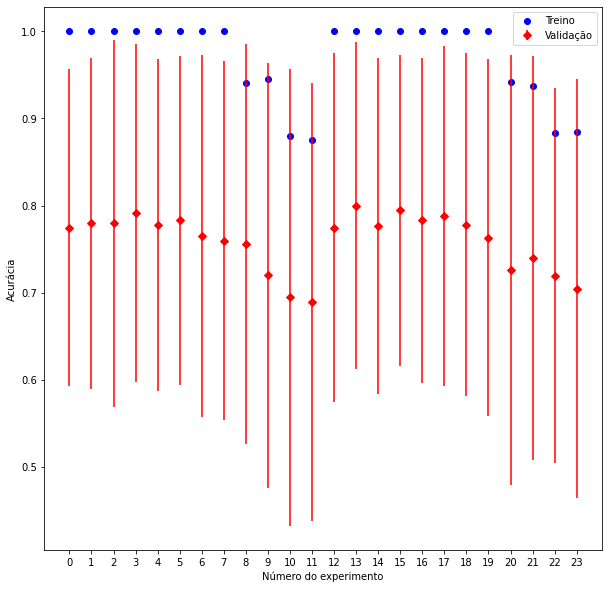

,params,mean_train_score,std_train_score,mean_test_score,std_test_score
13,"{'random__max_depth': 10, 'random__min_samples_split': 2, 'random__n_estimators': 100}",1.00,0.00,0.80,0.19


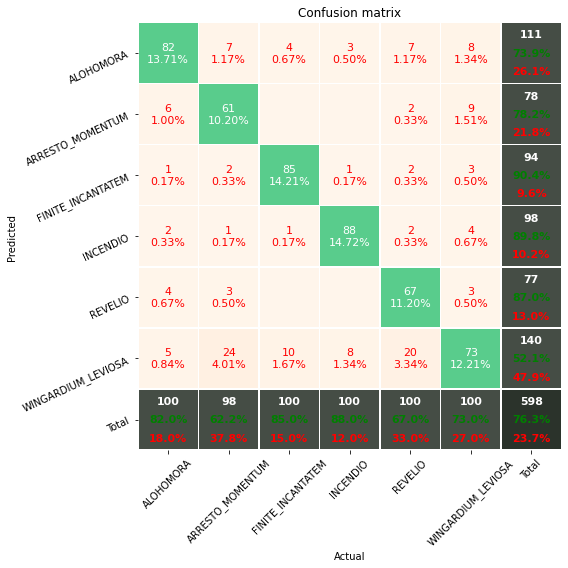

Pipeline(steps=[('random', RandomForestClassifier(max_depth=10))])

In [31]:
pipe = Pipeline([
    ('random', RandomForestClassifier())
])

parameters = {
         'random__min_samples_split': [2, 5, 7, 10, 50, 100],
         'random__n_estimators': [90, 100],
         'random__max_depth': [None, 10],
        }
 
grid_search(pipe, parameters, X_processed, database_train.y, database_train.cv_author, n_jobs=6)

O número mínimo de amostras necessárias para dividir um nó interno se mostrou ser 2, esse é o padrão da biblioteca e utilizaremos ele e com isso o números de "estimadores" ideal também passou a ser o padrão da biblioteca que é 100. Passaremos a utilizar ele de agora em diante.

### Testando max features

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    4.4s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    5.0s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:   14.4s
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:   21.3s
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:   29.7s
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   40.8s
[Parallel(n_jobs=6)]: Done  49 tasks      | elapsed:   52.4s
[Parallel(n_jobs=6)]: Done  67 out of  70 | elapsed:  1.2min remaining:    3.3s
[Parallel(n_jobs=6)]: Done  70 out of  70 | elapsed:  1.3min finished


,params,mean_train_score,std_train_score,mean_test_score,std_test_score
0,"{'random__max_depth': None, 'random__max_features': 0.6}",1.00,0.00,0.75,0.22
1,"{'random__max_depth': None, 'random__max_features': 0.65}",1.00,0.00,0.77,0.20
2,"{'random__max_depth': None, 'random__max_features': 0.7}",1.00,0.00,0.76,0.21
3,"{'random__max_depth': None, 'random__max_features': 0.73}",1.00,0.00,0.76,0.21
4,"{'random__max_depth': None, 'random__max_features': 0.7500000000000001}",1.00,0.00,0.77,0.21
5,"{'random__max_depth': None, 'random__max_features': 0.78}",1.00,0.00,0.76,0.21
6,"{'random__max_depth': None, 'random__max_features': 0.8}",1.00,0.00,0.76,0.20
7,"{'random__max_depth': 10, 'random__max_features': 0.6}",1.00,0.00,0.78,0.19
8,"{'random__max_depth': 10, 'random__max_features': 0.65}",1.00,0.00,0.77,0.20
9,"{'random__max_depth': 10, 'random__max_features': 0.7}",1.00,0.00,0.77,0.21


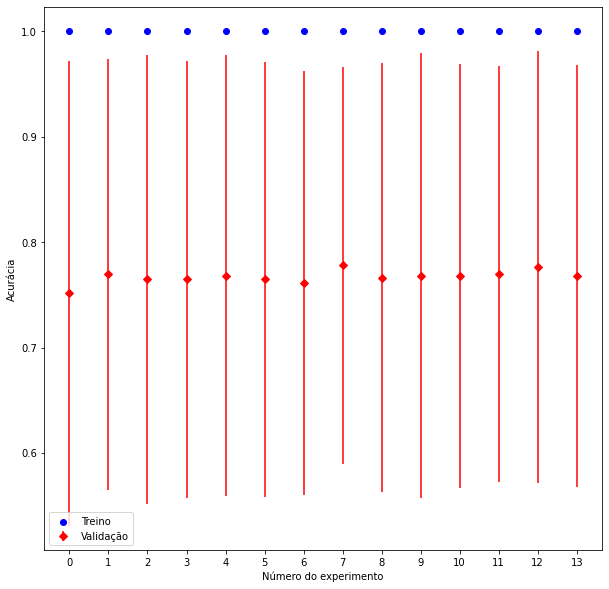

,params,mean_train_score,std_train_score,mean_test_score,std_test_score
7,"{'random__max_depth': 10, 'random__max_features': 0.6}",1.00,0.00,0.78,0.19


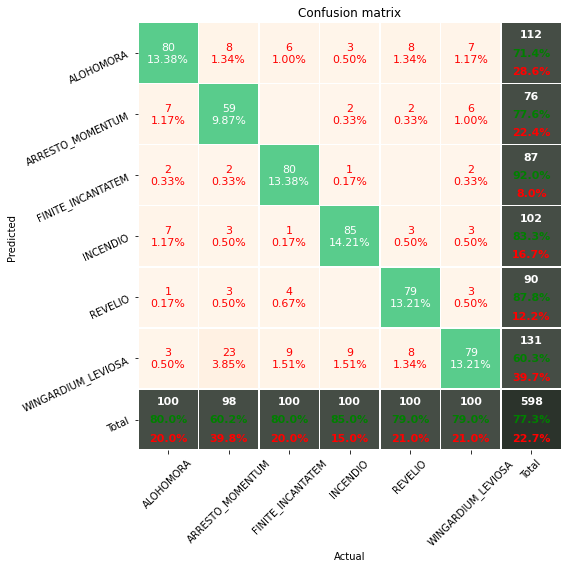

Pipeline(steps=[('random',
                 RandomForestClassifier(max_depth=10, max_features=0.6))])

In [32]:
pipe = Pipeline([
    ('random', RandomForestClassifier())
])

parameters = {
         'random__max_depth': [None, 10],
         'random__max_features': [0.6, 0.65, 0.7, 0.73, 0.7500000000000001, 0.78, 0.8],
        }
 
grid_search(pipe, parameters, X_processed, database_train.y, database_train.cv_author, n_jobs=6)

O melhor resultado obtido foi utilizando no máximo 60% das features. \
Com isso, os resultados variando individualmente cada parametro foi um pouco diferente dos resultados obtidos variando simultaneamente todos eles. \
Variando simultaneamente obtivemos: Pipeline(steps=[('random', RandomForestClassifier(max_features=0.78, min_samples_leaf=10, min_samples_split=5))]) \
e variando invidivualmente obtivemos: Pipeline(steps=[('random', RandomForestClassifier(max_depth= 10, max_features=0.6))]) \
Vamos comparar agora os dois resultados

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    6.1s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    6.7s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:   14.7s
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:   19.9s
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:   31.0s
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   40.1s
[Parallel(n_jobs=6)]: Done  49 tasks      | elapsed:   50.6s
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed:   59.9s
[Parallel(n_jobs=6)]: Done  78 out of  80 | elapsed:  1.3min remaining:    2.0s
[Parallel(n_jobs=6)]: Done  80 out of  80 | elapsed:  1.3min finished


,params,mean_train_score,std_train_score,mean_test_score,std_test_score
0,"{'random__max_depth': None, 'random__max_features': 0.6, 'random__min_samples_leaf': 1, 'random__min_samples_split': 2}",1.00,0.00,0.76,0.21
1,"{'random__max_depth': None, 'random__max_features': 0.6, 'random__min_samples_leaf': 1, 'random__min_samples_split': 5}",1.00,0.00,0.77,0.21
2,"{'random__max_depth': None, 'random__max_features': 0.6, 'random__min_samples_leaf': 10, 'random__min_samples_split': 2}",0.96,0.02,0.72,0.24
3,"{'random__max_depth': None, 'random__max_features': 0.6, 'random__min_samples_leaf': 10, 'random__min_samples_split': 5}",0.97,0.01,0.72,0.23
4,"{'random__max_depth': None, 'random__max_features': 0.78, 'random__min_samples_leaf': 1, 'random__min_samples_split': 2}",1.00,0.00,0.76,0.21
5,"{'random__max_depth': None, 'random__max_features': 0.78, 'random__min_samples_leaf': 1, 'random__min_samples_split': 5}",1.00,0.00,0.77,0.21
6,"{'random__max_depth': None, 'random__max_features': 0.78, 'random__min_samples_leaf': 10, 'random__min_samples_split': 2}",0.96,0.02,0.74,0.23
7,"{'random__max_depth': None, 'random__max_features': 0.78, 'random__min_samples_leaf': 10, 'random__min_samples_split': 5}",0.96,0.02,0.71,0.25
8,"{'random__max_depth': 10, 'random__max_features': 0.6, 'random__min_samples_leaf': 1, 'random__min_samples_split': 2}",1.00,0.00,0.78,0.19
9,"{'random__max_depth': 10, 'random__max_features': 0.6, 'random__min_samples_leaf': 1, 'random__min_samples_split': 5}",1.00,0.00,0.77,0.20


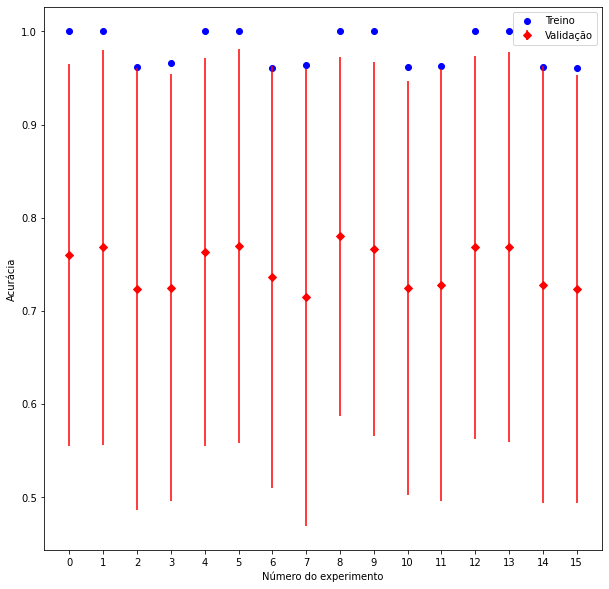

,params,mean_train_score,std_train_score,mean_test_score,std_test_score
8,"{'random__max_depth': 10, 'random__max_features': 0.6, 'random__min_samples_leaf': 1, 'random__min_samples_split': 2}",1.00,0.00,0.78,0.19


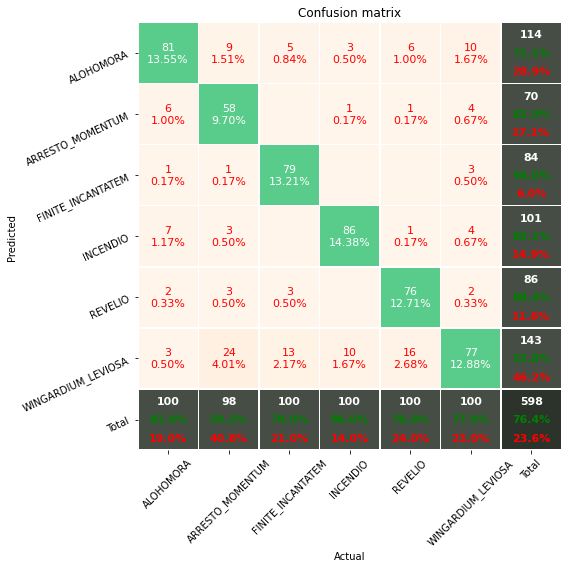

Pipeline(steps=[('random',
                 RandomForestClassifier(max_depth=10, max_features=0.6))])

In [34]:
pipe = Pipeline([
    ('random', RandomForestClassifier())
])

parameters = {
         'random__max_depth': [None, 10],
         'random__max_features': [0.6, 0.78],
         'random__min_samples_leaf': [1, 10],
         'random__min_samples_split': [2, 5],
         'random__max_depth': [None, 10]
        }
 
grid_search(pipe, parameters, X_processed, database_train.y, database_train.cv_author, n_jobs=6)

Com isso, o resultado dos experimentos variando individualmente cada parametro se provaram melhores que a variação simultanea.

### Testando warm_start

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of  10 | elapsed:    4.6s remaining:   10.7s
[Parallel(n_jobs=6)]: Done   5 out of  10 | elapsed:    4.8s remaining:    4.8s
[Parallel(n_jobs=6)]: Done   7 out of  10 | elapsed:    7.6s remaining:    3.3s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    7.8s finished


,params,mean_train_score,std_train_score,mean_test_score,std_test_score
0,{'random__warm_start': True},1.00,0.00,0.77,0.20
1,{'random__warm_start': False},1.00,0.00,0.76,0.21


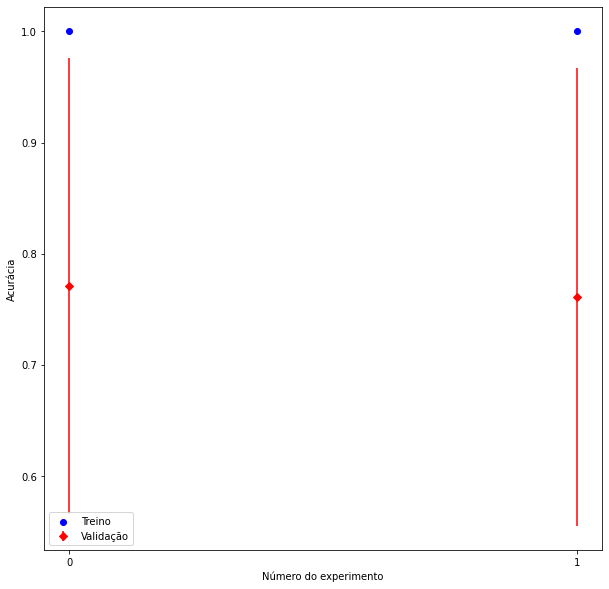

,params,mean_train_score,std_train_score,mean_test_score,std_test_score
0,{'random__warm_start': True},1.00,0.00,0.77,0.20


/home/guilherme/.local/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:368: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "
/home/guilherme/.local/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:368: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "
/home/guilherme/.local/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:368: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "
/home/guilherme/.local/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:368: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


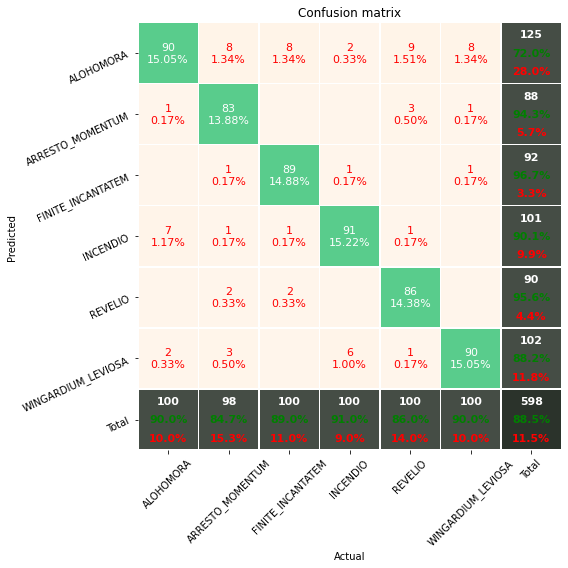

Pipeline(steps=[('random',
                 RandomForestClassifier(max_depth=10, max_features=0.6,
                                        warm_start=True))])

In [37]:
pipe = Pipeline([
    ('random', RandomForestClassifier(max_depth=10, max_features=0.6))
])

parameters = {
         'random__warm_start': [True, False]
        }
 
grid_search(pipe, parameters, X_processed, database_train.y, database_train.cv_author, n_jobs=6)

O ganho em utilizar soluções prévias para encontrar o fit nos leva a pouco ganho, portanto iremos utilizar o padrão da biblioteca que é False

### Testando class_weight

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    4.5s
[Parallel(n_jobs=6)]: Done   6 out of  15 | elapsed:    5.0s remaining:    7.5s
[Parallel(n_jobs=6)]: Done   8 out of  15 | elapsed:   10.1s remaining:    8.9s
[Parallel(n_jobs=6)]: Done  10 out of  15 | elapsed:   10.4s remaining:    5.2s
[Parallel(n_jobs=6)]: Done  12 out of  15 | elapsed:   10.6s remaining:    2.6s
[Parallel(n_jobs=6)]: Done  15 out of  15 | elapsed:   13.6s finished


,params,mean_train_score,std_train_score,mean_test_score,std_test_score
0,{'random__class_weight': 'balanced'},1.00,0.00,0.77,0.20
1,{'random__class_weight': 'balanced_subsample'},1.00,0.00,0.76,0.21
2,{'random__class_weight': None},1.00,0.00,0.77,0.20


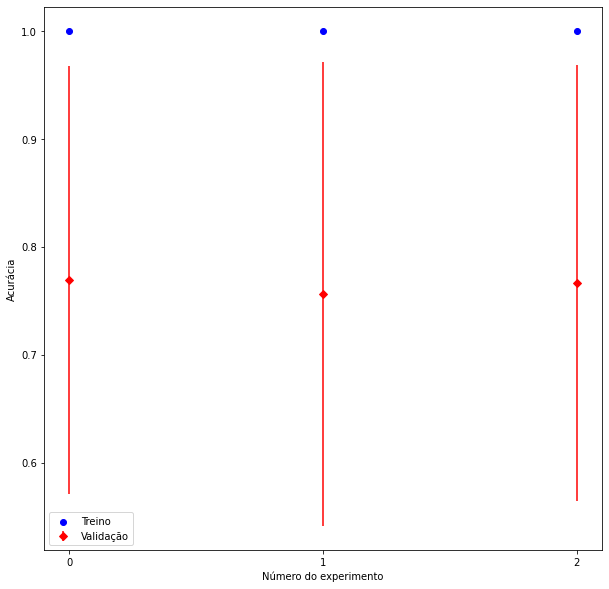

,params,mean_train_score,std_train_score,mean_test_score,std_test_score
0,{'random__class_weight': 'balanced'},1.00,0.00,0.77,0.20


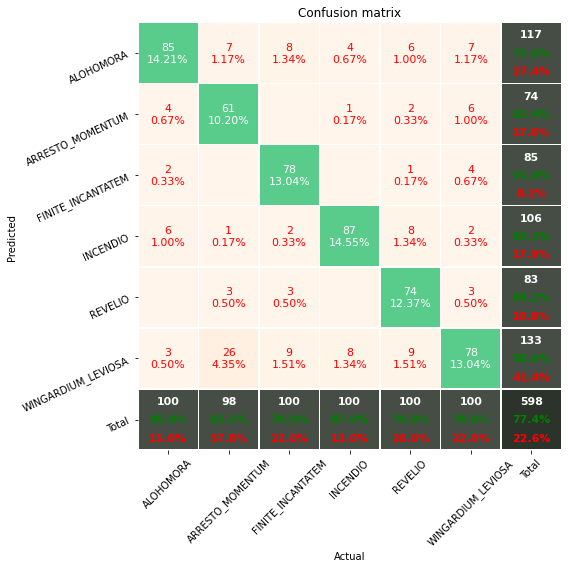

Pipeline(steps=[('random',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        max_features=0.6))])

In [39]:
pipe = Pipeline([
    ('random', RandomForestClassifier(max_depth=10, max_features=0.6))
])

parameters = {
         'random__class_weight': ["balanced", "balanced_subsample", None]
        }
 
grid_search(pipe, parameters, X_processed, database_train.y, database_train.cv_author, n_jobs=6)

Como a diferença entre os métodos colocando peso nas classes ou não foi mínima, utilizaremos o padrão da biblioteca que é None, ou seja, todas as classes tem peso 1

## Como o indice gini é calculado no método
O índice Gini diz que se selecionarmos aleatoriamente dois itens de uma população, então ambos devem ser da mesma classe e a probabilidade disto é 1 se a população for pura. \
    Funciona com a variável alvo categórica “Sucesso” ou “Falha” \
    Executa apenas divisões binárias \
    Quanto maior o valor de Gini, maior a homogeneidade \
    O CART (Árvore de Classificação e Regressão) usa o método Gini para criar divisões binárias \
Passos para calcular o Gini de uma divisão: \
    Cálculo do Gini para sub-nós, calcule a soma dos quadrados da probabilidade de sucesso e e da de fracasso (p ^ 2 + q ^ 2) \
    Calcule o Gini para a divisão, use a pontuação de Gini ponderada de cada nó dessa divisão \

## Quando utilizar modelos lineares ou baseados e árvore?
1. Se a relação entre a variável dependente e a independente for bem aproximada por um modelo linear, a regressão linear terá uma performance melhor que o modelo baseado em árvore
2. Se houver uma relação de alta não linearidade e complexidade entre as variáveis dependentes e as independentes, um modelo de árvore irá superar um método de regressão clássica
3. Se você precisa construir um modelo que seja fácil de explicar às pessoas, um modelo de árvore de decisão sempre será melhor do que um modelo linear. Os modelos de árvores de decisão são ainda mais simples de interpretar do que a regressão linear!
